In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, shape
import geopandas as gpd
import pickle

# Import custom functions from `scripts` folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from scripts.clean_tweets import geometrize_tweets, convert_shapefile_crs, find_frequencies


pd.set_option('display.max_columns', 999)

# Loading data

In [49]:
# Read tweets
bo14 = pd.read_csv('../data/tweets/bo_2014.csv')
bo15 = pd.read_csv('../data/tweets/bo_2015.csv')

In [53]:
# Convert to GeoDataFrame based on lat/lon
bo14 = geometrize_tweets(bo14)
bo15 = geometrize_tweets(bo15)

In [32]:
# Read shapefiles
bogota = gpd.read_file('../data/shapefiles/bogota_shapefiles/shp_secciondata.shp')
elbronx = gpd.read_file('../data/shapefiles/bogota_neighborhood_shapefiles/barrios_bronx.shp')

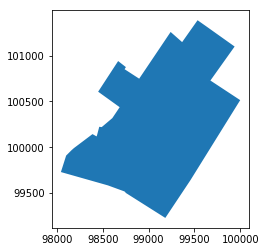

In [33]:
# Visualize El Bronx; note that the CRS is not WGS84
elbronx.plot()

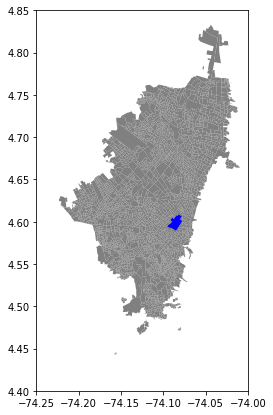

In [34]:
# Convert elbronx to WGS84, then visualize El Bronx on top of Bogota
elbronx = convert_shapefile_crs(elbronx)

fig, ax = plt.subplots(figsize=(10, 7))
bogota.plot(ax=ax, color='gray')
elbronx.plot(ax=ax, color='blue')
ax.set_ylim(4.4, 4.85)
ax.set_xlim(-74.25, -74);

# Assign tracts to tweets

We are interested in two features:

1. Whether or not a tweet is generated from El Bronx.
1. Whether or not a tweet is within 0.5 miles of El Bronx

## 1: El Bronx neighborhood

In [36]:
# Compute a spatial join between tweets and elbronx
bo14_neighborhood = gpd.sjoin(bo14, elbronx, how='left', op='intersects')
bo15_neighborhood = gpd.sjoin(bo15, elbronx, how='left', op='intersects')

In [3]:
#### Save bo14_neighborhood and bo15_neighborhood for easy loading
# with open('bo14_neighborhood.pkl', 'wb') as file:
#     pickle.dump(bo14_neighborhood, file)
# with open('bo15_neighborhood.pkl', 'wb') as file:
#     pickle.dump(bo15_neighborhood, file)
    
with open('../data/bo14_neighborhood.pkl', 'rb') as file:
    bo14_neighborhood = pickle.load(file)
with open('../data/bo15_neighborhood.pkl', 'rb') as file:
    bo15_neighborhood = pickle.load(file)

In [3]:
bo15_neighborhood.head()

,id,u_id,lat,lon,created_at,type,place_type,u_created_at,u_followers_count,u_location,u_lang,u_statuses_count,u_name,u_screen_name,u_description,urls,text,geometry,index_right,br_diss
0,550830144861265922,925965594,4.934843,-74.021885,1420163115000,llp,city,1352057000000,727,Cajica,es,18452,Karen Daniela,Karen_DanielaSF,Wilder Medina 11. 15 julio 2012\r\n\r\nContado...,NaN,Trato de dar lo mejor de mi para que no valore...,POINT (-74.021885 4.934843),NaN,NaN
1,550830148678062080,405997219,4.665143,-74.136186,1420163116000,llp,city,1320549678000,233,NaN,es,9890,PiernasFlacas,DianaErre,"No tengo los ojos azules, pero si el corazón. ...",NaN,&lt;----Nuevo avatar 🙈,POINT (-74.136186 4.665143),NaN,NaN
2,550830400013336576,428542794,4.587158,-74.087265,1420163175000,llp,city,1323036195000,183,NaN,es,3630,♥PDC†‏Martinez★,Regalametusojos,Siendo Pieza Del cubo soy feliz :) #PDC,NaN,"Nathalia : luce fría, pero me ve llorar y en s...",POINT (-74.087265 4.587158000000001),NaN,NaN
3,550830856231997440,1002147949,4.664712,-74.082039,1420163284000,llp,city,1355161608000,200,Bogota-Colombia,es,13414,Manuel Duarte,RodolfoDuarteC,Seras un nuevo comienzo,NaN,Todo se noto hasta ahora...,POINT (-74.08203899999999 4.664712000000001),NaN,NaN
4,550830868257079297,2695916110,4.878866,-74.065011,1420163287000,llp,city,1405018700000,443,NaN,es,13043,Daniela Dussán.,_Lost__Cause,Te amo Santi. ❤,NaN,"Pero también soy severa novia, loksJAJAJAJA 😞😔",POINT (-74.065011 4.878866),NaN,NaN


In [5]:
print(f"{(~bo14_neighborhood['br_diss'].isnull()).sum()} of {len(bo14_neighborhood)} 2014 tweets are from El Bronx")
print(f"{(~bo15_neighborhood['br_diss'].isnull()).sum()} of {len(bo15_neighborhood)} 2015 tweets are from El Bronx")

41970 of 10949137 2014 tweets are from El Bronx
47026 of 4056214 2015 tweets are from El Bronx


## 2: Within 0.5 miles of El Bronx

Our next objective is to find tweets within 0.5 miles of El Bronx. Instead of creating a buffer around El Bronx, we can instead create a 0.5 mile buffer around each tweet's location, then find all tweets that overlap with the geometry of El Bronx. The leftmost picture below illustrates this approach; we can consider the square to be the geometry of El Bronx, and the circle to be the geometry of a single tweet.

![](https://geopandas.readthedocs.io/en/latest/_images/overlay_operations.png)

Each degree of latitude is approximately 69 miles apart. For longitude to miles, at a given latitude, the conversion is as follows ([source](https://gis.stackexchange.com/questions/142326/calculating-longitude-length-in-miles)):

`1 degree of longitude` = `cosine(latitude in decimal)` * `length of degree (miles) at equator`

Then we compute:

In [56]:
# -74.8 is roughly the median latitude of El Bronx
np.cos(-74.8) * 69.172

57.15940333782036

1 degree of latitude is 69 miles, and 1 degree of longitude is 57.1594 miles. This means that 0.5 miles is represented by $\frac{0.5}{69} \approx 0.007246$ degrees of latitude and $\frac{0.5}{57.1594} \approx 0.008747$ degrees of longitude. A roughly 0.5 mile buffer can be established by creating a buffer of ~0.008 degrees around each tweet. 

In [70]:
BUFFER = 0.008

bo14_buffer, bo15_buffer = bo14.copy(), bo15.copy()
bo14_buffer['geometry'] = bo14_buffer.buffer(BUFFER)
bo15_buffer['geometry'] = bo15_buffer.buffer(BUFFER)

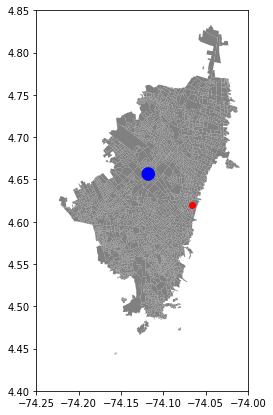

In [74]:
# One expanded tweet (blue), one regular tweet (red):
fig, ax = plt.subplots(figsize=(10, 7))
bogota.plot(ax=ax, color='gray')
bo15_buffer.sample(n=1).plot(ax=ax, color='blue')
bo15.sample(n=1).plot(ax=ax, color='red')
ax.set_ylim(4.4, 4.85)
ax.set_xlim(-74.25, -74);

In [4]:
### Save bo14_buffer and bo15_ for easy loading
# with open('bo14_buffer.pkl', 'wb') as file:
#     pickle.dump(bo14_buffer, file)
# with open('bo15_buffer.pkl', 'wb') as file:
#     pickle.dump(bo15_buffer, file)
    
with open('../data/bo14_buffer.pkl', 'rb') as file:
    bo14_buffer = pickle.load(file)
with open('../data/bo15_buffer.pkl', 'rb') as file:
    bo15_buffer = pickle.load(file)

In [8]:
bo15_buffer.head()

,id,u_id,lat,lon,created_at,type,place_type,u_created_at,u_followers_count,u_location,u_lang,u_statuses_count,u_name,u_screen_name,u_description,urls,text,geometry,index_right,br_diss
0,550830144861265922,925965594,4.934843,-74.021885,1420163115000,llp,city,1352057000000,727,Cajica,es,18452,Karen Daniela,Karen_DanielaSF,Wilder Medina 11. 15 julio 2012\r\n\r\nContado...,NaN,Trato de dar lo mejor de mi para que no valore...,"POLYGON ((-74.013885 4.934843, -74.01392352218...",NaN,NaN
1,550830148678062080,405997219,4.665143,-74.136186,1420163116000,llp,city,1320549678000,233,NaN,es,9890,PiernasFlacas,DianaErre,"No tengo los ojos azules, pero si el corazón. ...",NaN,&lt;----Nuevo avatar 🙈,"POLYGON ((-74.128186 4.665143, -74.12822452218...",NaN,NaN
2,550830400013336576,428542794,4.587158,-74.087265,1420163175000,llp,city,1323036195000,183,NaN,es,3630,♥PDC†‏Martinez★,Regalametusojos,Siendo Pieza Del cubo soy feliz :) #PDC,NaN,"Nathalia : luce fría, pero me ve llorar y en s...",POLYGON ((-74.07926500000001 4.587158000000001...,0.0,1.0
3,550830856231997440,1002147949,4.664712,-74.082039,1420163284000,llp,city,1355161608000,200,Bogota-Colombia,es,13414,Manuel Duarte,RodolfoDuarteC,Seras un nuevo comienzo,NaN,Todo se noto hasta ahora...,"POLYGON ((-74.074039 4.664712000000001, -74.07...",NaN,NaN
4,550830868257079297,2695916110,4.878866,-74.065011,1420163287000,llp,city,1405018700000,443,NaN,es,13043,Daniela Dussán.,_Lost__Cause,Te amo Santi. ❤,NaN,"Pero también soy severa novia, loksJAJAJAJA 😞😔","POLYGON ((-74.057011 4.878866, -74.05704952218...",NaN,NaN


In [9]:
print(f"{(~bo14_buffer['br_diss'].isnull()).sum()} of {len(bo14_buffer)} 2014 tweets are from El Bronx + buffer")
print(f"{(~bo15_buffer['br_diss'].isnull()).sum()} of {len(bo15_buffer)} 2015 tweets are from El Bronx + buffer")

313305 of 10949137 2014 tweets are from El Bronx + buffer
166876 of 4056214 2015 tweets are from El Bronx + buffer


# Analysis of "La L" and "El Bronx" frequencies

First, we preprocess to add boolean columns (just for convenience). `bo14_neighborhood` and `bo15_neighborhood` are for tweets that are *just* from the El Bronx tract, and `bo14_buffer` and `bo15_buffer` are for tweets that are from El Bronx + buffer. We also add a column for the hour:

In [6]:
bo14_neighborhood['bronx'] = ~bo14_neighborhood['br_diss'].isnull()
bo15_neighborhood['bronx'] = ~bo15_neighborhood['br_diss'].isnull()
bo14_buffer['bronx_buffer'] = ~bo14_buffer['br_diss'].isnull()
bo15_buffer['bronx_buffer'] = ~bo15_buffer['br_diss'].isnull()

bo14_neighborhood['hour'] = pd.to_datetime(bo14_neighborhood['created_at'] // 1000, unit='s').dt.hour
bo15_neighborhood['hour'] = pd.to_datetime(bo14_neighborhood['created_at'] // 1000, unit='s').dt.hour
bo14_buffer['hour'] = pd.to_datetime(bo14_buffer['created_at'] // 1000, unit='s').dt.hour
bo15_buffer['hour'] = pd.to_datetime(bo14_buffer['created_at'] // 1000, unit='s').dt.hour

We first observe all tweets (regardless of timestamp). For "La L", to avoid any overlap with other words, we check for two patterns:

- "La L " (with a whitespace following "L")
- "La L"  (if "L" is the last character in the tweet)

In [10]:
# All tweets sent from El Bronx
print('{} of {} tweets sent from El Bronx in 2014 contain "el bronx"'.format(
    *find_frequencies(bo14_neighborhood.loc[bo14_neighborhood['bronx'], 'text'], r'el bronx')))
print('{} of {} tweets sent from El Bronx in 2015 contain "el bronx"'.format(
    *find_frequencies(bo15_neighborhood.loc[bo15_neighborhood['bronx'], 'text'], r'el bronx')))
print()
print('{} of {} tweets sent from El Bronx in 2014 contain "la l"'.format(
    *find_frequencies(bo14_neighborhood.loc[bo14_neighborhood['bronx'], 'text'], r'(la l[\s.,-])|(la l$)')))
print('{} of {} tweets sent from El Bronx in 2015 contain "la l"'.format(
    *find_frequencies(bo15_neighborhood.loc[bo15_neighborhood['bronx'], 'text'], r'(la l[\s.,-])|(la l$)')))

15 of 41970 tweets sent from El Bronx in 2014 contain "el bronx"
4 of 47026 tweets sent from El Bronx in 2015 contain "el bronx"



/scratch/public/jsp/twitter-and-displacement/02_analysis/scripts/clean_tweets.py:84: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  num_matches = series.str.contains(pat, case=case).sum()


3 of 41970 tweets sent from El Bronx in 2014 contain "la l"
2 of 47026 tweets sent from El Bronx in 2015 contain "la l"


In [11]:
# All tweets made from El Bronx + buffer
print('{} of {} tweets sent from El Bronx + buffer in 2014 contain "el bronx"'.format(
    *find_frequencies(bo14_buffer.loc[bo14_buffer['bronx_buffer'], 'text'], r'el bronx')))
print('{} of {} tweets sent from El Bronx + buffer in 2015 contain "el bronx"'.format(
    *find_frequencies(bo15_buffer.loc[bo15_buffer['bronx_buffer'], 'text'], r'el bronx')))
print()
print('{} of {} tweets sent from El Bronx + buffer in 2014 contain "la l"'.format(
    *find_frequencies(bo14_buffer.loc[bo14_buffer['bronx_buffer'], 'text'], r'(la l[\s.,-])|(la l$)')))
print('{} of {} tweets sent from El Bronx + buffer in 2015 contain "la l"'.format(
    *find_frequencies(bo15_buffer.loc[bo15_buffer['bronx_buffer'], 'text'], r'(la l[\s.,-])|(la l$)')))

24 of 313305 tweets sent from El Bronx + buffer in 2014 contain "el bronx"
9 of 166876 tweets sent from El Bronx + buffer in 2015 contain "el bronx"

11 of 313305 tweets sent from El Bronx + buffer in 2014 contain "la l"
3 of 166876 tweets sent from El Bronx + buffer in 2015 contain "la l"


Next, we look at the subset of times 8pm-4am (during which we think that people are mostly at home only if they are residents):

In [12]:
# All tweets sent from El Bronx between 8pm-4am
print('{} of {} tweets sent from El Bronx in 2014 between 8pm-4am contain "el bronx"'.format(
    *find_frequencies(bo14_neighborhood.loc[(bo14_neighborhood['bronx']) & 
                                            ((bo14_neighborhood['hour'] >= 18) | 
                                            (bo14_neighborhood['hour'] <= 4)), 'text'], r'el bronx')))
print('{} of {} tweets sent from El Bronx in 2015 between 8pm-4am contain "el bronx"'.format(
    *find_frequencies(bo15_neighborhood.loc[(bo15_neighborhood['bronx']) & 
                                            ((bo15_neighborhood['hour'] >= 18) |
                                            (bo15_neighborhood['hour'] <= 4)), 'text'], r'el bronx')))
print()
print('{} of {} tweets sent from El Bronx in 2014 between 8pm-4am contain "la l"'.format(
    *find_frequencies(bo14_neighborhood.loc[(bo14_neighborhood['bronx']) & 
                                            ((bo14_neighborhood['hour'] >= 18) | 
                                            (bo14_neighborhood['hour'] <= 4)), 'text'], r'(la l[\s.,-])|(la l$)')))
print('{} of {} tweets sent from El Bronx in 2015 between 8pm-4am contain "la l"'.format(
    *find_frequencies(bo15_neighborhood.loc[(bo14_neighborhood['bronx']) & 
                                            ((bo14_neighborhood['hour'] >= 18) | 
                                            (bo14_neighborhood['hour'] <= 4)), 'text'], r'(la l[\s.,-])|(la l$)')))

9 of 25341 tweets sent from El Bronx in 2014 between 8pm-4am contain "el bronx"
3 of 30842 tweets sent from El Bronx in 2015 between 8pm-4am contain "el bronx"

1 of 25341 tweets sent from El Bronx in 2014 between 8pm-4am contain "la l"
0 of 9519 tweets sent from El Bronx in 2015 between 8pm-4am contain "la l"


In [13]:
# All tweets sent from El Bronx + buffer between 8pm-4am
print('{} of {} tweets sent from El Bronx + buffer in 2014 between 8pm-4am contain "el bronx"'.format(
    *find_frequencies(bo14_buffer.loc[(bo14_buffer['bronx_buffer']) & 
                                            ((bo14_buffer['hour'] >= 18) | 
                                            (bo14_buffer['hour'] <= 4)), 'text'], r'el bronx')))
print('{} of {} tweets sent from El Bronx + buffer in 2015 between 8pm-4am contain "el bronx"'.format(
    *find_frequencies(bo15_buffer.loc[(bo15_buffer['bronx_buffer']) & 
                                            ((bo15_buffer['hour'] >= 18) | 
                                            (bo15_buffer['hour'] <= 4)), 'text'], r'el bronx')))
print()
print('{} of {} tweets sent from El Bronx + buffer in 2014 between 8pm-4am contain "la l"'.format(
    *find_frequencies(bo14_buffer.loc[(bo14_buffer['bronx_buffer']) & 
                                            ((bo14_buffer['hour'] >= 18) |
                                            (bo14_buffer['hour'] <= 4)), 'text'], r'(la l[\s.,-])|(la l$)')))
print('{} of {} tweets sent from El Bronx + buffer in 2015 between 8pm-4am contain "la l"'.format(
    *find_frequencies(bo15_buffer.loc[(bo14_buffer['bronx_buffer']) & 
                                            ((bo14_buffer['hour'] >= 18) | 
                                            (bo14_buffer['hour'] <= 4)), 'text'], r'(la l[\s.,-])|(la l$)')))

12 of 191464 tweets sent from El Bronx + buffer in 2014 between 8pm-4am contain "el bronx"
5 of 110249 tweets sent from El Bronx + buffer in 2015 between 8pm-4am contain "el bronx"

5 of 191464 tweets sent from El Bronx + buffer in 2014 between 8pm-4am contain "la l"
2 of 71676 tweets sent from El Bronx + buffer in 2015 between 8pm-4am contain "la l"


For context, here are the number of total tweets sent in Bogota in each of 2014 and 2015:

In [50]:
print(f'{len(bo14)} tweets in Bogota in 2014')
print(f'{len(bo15)} tweets in Bogota in 2015')

10949137 tweets in Bogota in 2014
4056214 tweets in Bogota in 2015
